In [34]:
!pip install groq shap lime pandas matplotlib seaborn scikit-learn transformers nltk dotenv bs4


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [35]:
# ============================================================================
# 1. SETUP AND IMPORTS
# ============================================================================

import pandas as pd
import numpy as np
import re
import time
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# LLM Integration
from groq import Groq

# NLP and Evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# XAI Libraries
import shap
from lime.lime_text import LimeTextExplainer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

from tqdm import tqdm

# Download required NLTK data
try:
    nltk.download('vader_lexicon', quiet=True)
except:
    pass

In [3]:
import sys
import os
from dotenv import load_dotenv
load_dotenv()
if 'google.colab' in sys.modules:
    from google.colab import userdata
    GROQ_API_KEY = userdata.get("GROQ_API_KEY")
    print("Running in Google Colab")
    IN_COLAB = True
else:
    print("Not running in Google Colab")
    GROQ_API_KEY = os.getenv("GROQ_API_KEY")
    IN_COLAB = False

Not running in Google Colab


In [4]:
# ============================================================================
# 2. GROQ CLIENT SETUP
# ============================================================================

# Initialize Groq client
MODEL_NAME = "llama-3.1-8b-instant"

client = Groq(api_key=GROQ_API_KEY)

In [ ]:
def query_llm(prompt: str, model: str, max_retries: int = 3) -> str:
    """Query Llama 3.3-70B via Groq with retry logic"""
    for attempt in range(max_retries):
        try:
            response = client.chat.completions.create(
                model=model,
                messages=[{"role": "user", "content": prompt}],
                temperature=0.0,  # Deterministic for consistency
                max_tokens=1024,
                top_p=1,
            )
            return response.choices[0].message.content.strip()
        except Exception as e:
            if attempt < max_retries - 1:
                time.sleep(2 ** attempt)  # Exponential backoff
                continue
            else:
                print(f"Error after {max_retries} attempts: {e}")
                return ""

In [6]:
# ============================================================================
# 3. DATA LOADING AND PREPROCESSING
# ============================================================================

print("\n" + "=" * 80)
print("DATA LOADING AND PREPROCESSING")
print("=" * 80)

DATAFILE_NAME= 'Financial-QA-10k-sampled.csv'
DATA_PATH = f'../Datasets/{DATAFILE_NAME}'
if not os.path.exists(DATA_PATH):
    DATA_PATH = f'{DATAFILE_NAME}'  # Colab path
# Load dataset (replace with your actual path)
df = pd.read_csv(DATA_PATH)

OUTPUT_PATH = f'../Outputs/Few-Shot/{MODEL_NAME}_1/'

if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

print(f"\n Dataset loaded: {len(df)} records")
print(f" Columns: {list(df.columns)}")


DATA LOADING AND PREPROCESSING

 Dataset loaded: 1675 records
 Columns: ['question', 'answer', 'context', 'ticker', 'filing', 'word_count']


In [7]:
from bs4 import BeautifulSoup

# Text Cleaning Function
def clean_text(text: str) -> str:
    """Clean and normalize text"""
    if pd.isna(text):
        return ""
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    # Remove special characters but keep basic punctuation
    text = re.sub(r'[^\w\s.,!?-]', '', text)
    return text.strip()

def clean_html(text: str) -> str:
    """Remove HTML tags and entities."""
    if pd.isna(text):
        return ""

    # Parse HTML and extract text
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()

    # Clean up HTML entities
    text = re.sub(r'&[a-zA-Z]+;', ' ', text)
    text = re.sub(r'&#[0-9]+;', ' ', text)

    return text

def clean_special_chars(text: str) -> str:
    """Remove special characters and normalize text."""
    if not text:
        return ""

    # Remove URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', text)
    text = re.sub(r'www\.(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', text)

    # Remove email addresses
    text = re.sub(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\\.[a-zA-Z]{2,}', ' ', text)

    # Clean excessive whitespace
    text = re.sub(r'\\s+', ' ', text)

    # Remove excessive punctuation
    text = re.sub(r'[!]{2,}', '!', text)
    text = re.sub(r'[?]{2,}', '?', text)
    text = re.sub(r'[.]{3,}', '...', text)

    return text.strip()

def normalize_case(text: str) -> str:
    """Normalize text case while preserving proper nouns."""
    if not text:
        return ""

    # Convert to lowercase but preserve some financial terms
    financial_terms = ['USD', 'CEO', 'CFO', 'SEC', 'GAAP', 'EBITDA', 'ROI', 'IPO', 'NYSE', 'NASDAQ']

    # Temporarily replace financial terms
    temp_replacements = {}
    for i, term in enumerate(financial_terms):
        if term in text:
            placeholder = f"__FINANCIAL_TERM_{i}__"
            temp_replacements[placeholder] = term
            text = text.replace(term, placeholder)

    # Convert to lowercase
    text = text.lower()

    # Restore financial terms
    for placeholder, original in temp_replacements.items():
        text = text.replace(placeholder, original)

    return text

def preprocess(text: str) -> str:
    """Apply all preprocessing steps."""
    # Step 1: Clean HTML
    text = clean_html(text)

    # Step 2: Clean special characters
    text = clean_special_chars(text)

    # Step 3: Normalize case
    text = normalize_case(text)
    return text

In [8]:
# Apply cleaning
df['question'] = df['question'].apply(clean_text)
df['answer'] = df['answer'].apply(clean_text)
df['context'] = df['context'].apply(clean_text)
df['combined_text'] = df['question'] + ' ' + df['answer'] + ' ' + df['context']
df['combined_text'] = df['combined_text'].apply(preprocess)

print(" Text cleaning completed")

 Text cleaning completed


In [9]:
# ============================================================================
# 4. GROUND TRUTH LABEL GENERATION
# ============================================================================

print("\n" + "=" * 80)
print("GENERATING GROUND TRUTH LABELS")
print("=" * 80)

# (A) SENTIMENT LABELS - Derived from context
sia = SentimentIntensityAnalyzer()

def get_sentiment_label(text: str) -> str:
    """Derive sentiment label using VADER"""
    score = sia.polarity_scores(text)['compound']
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_true'] = df['combined_text'].apply(get_sentiment_label)
# df['sentiment_true'] = df['context'].apply(get_sentiment_label)
print(f"\n Sentiment labels generated")
print(f"  Distribution: {df['sentiment_true'].value_counts().to_dict()}")

# (B) TOPIC LABELS - Derived from questions
def get_topic_label(question: str) -> str:
    """Extract topic from question using keyword matching"""
    q = question.lower()
    if any(word in q for word in ['revenue', 'sales', 'income', 'profit']):
        return 'Revenue'
    elif any(word in q for word in ['risk', 'threat', 'challenge', 'vulnerability']):
        return 'Risk'
    elif any(word in q for word in ['operation', 'efficiency', 'process', 'performance']):
        return 'Operations'
    elif any(word in q for word in ['legal', 'litigation', 'lawsuit', 'compliance']):
        return 'Legal'
    elif any(word in q for word in ['management', 'executive', 'leadership', 'board']):
        return 'Management'
    else:
        return 'Other'

df['topic_true'] = df['question'].apply(get_topic_label)
print(f"\n Topic labels generated")
print(f"  Distribution: {df['topic_true'].value_counts().to_dict()}")



GENERATING GROUND TRUTH LABELS

 Sentiment labels generated
  Distribution: {'Positive': 1197, 'Neutral': 258, 'Negative': 220}

 Topic labels generated
  Distribution: {'Other': 1224, 'Revenue': 219, 'Legal': 98, 'Operations': 51, 'Management': 45, 'Risk': 38}


In [10]:
# ============================================================================
# 5. FEW-SHOT PROMPT TEMPLATES
# ============================================================================

print("\n" + "=" * 80)
print("Few-SHOT PROMPT DESIGN")
print("=" * 80)

def create_qa_prompt(question: str, context: str) -> str:
    """Few-shot prompt for Question Answering"""
    return f"""You are a financial analysis expert. Your task is to answer questions strictly based on the provided context from a 10-K filing.

Follow these rules:
- Use only the information in the context. Do not use external knowledge.
- Provide a concise and accurate answer, in plain-text ONLY, based solely on the information in the context.
- If the answer cannot be derived from the context, respond with: "Cannot be determined from the context."

Here are examples:

Example 1:
Context: "Revenue increased by 12% year-over-year, driven primarily by higher subscription sales in North America."
Question: "What was the main driver of revenue growth?"
Answer: "Higher subscription sales in North America."

Example 2:
Context: "The company identified supply chain disruptions as a significant risk that may impact product delivery timelines."
Question: "What risk could affect product delivery?"
Answer: "Supply chain disruptions."

Example 3:
Context: "Operating expenses remained consistent with the prior year, with only minor fluctuations across departments."
Question: "Did operating expenses materially change from the prior year?"
Answer: "No, they remained consistent."

Example 4:
Context: "The company plans to expand its manufacturing facility in 2025 but has not yet provided specific cost estimates."
Question: "Has the company disclosed the projected cost of the expansion?"
Answer: "No, cost estimates have not been provided."

Example 5:
Context: "Management stated that foreign currency fluctuations had no material effect on the consolidated financial statements."
Question: "Did foreign currency fluctuations materially affect results?"
Answer: "No, they had no material effect."

Example 6:
Context: "The filing notes that while the company is evaluating new product opportunities, no formal product launches are scheduled for the next fiscal year."
Question: "Are any new product launches scheduled for next year?"
Answer: "No, none are scheduled."

Now answer the following question.

Context: {context}

Question: {question}

Answer:(Copy the exact answer from the context)
"""

def create_sentiment_prompt(text: str) -> str:
    """Few-shot prompt for Sentiment Detection"""
    return f"""You are a financial sentiment analysis expert. Your task is to classify the sentiment of financial text.
Classify each text as exactly one of: Positive, Negative, or Neutral.

Follow these rules:
- Consider financial terminology, macro events, and market context.
- Focus on the author’s attitude toward financial performance, outlook, or risk.
- Respond with only the sentiment label (one word): Positive, Negative, or Neutral.

Here are examples:

Example 1:
Text: "The company reported strong quarterly earnings, beating analyst expectations across all segments."
Sentiment: Positive

Example 2:
Text: "The firm expects a significant decline in revenue due to weakening demand in international markets."
Sentiment: Negative

Example 3:
Text: "The stock traded flat today despite moderate trading volume and no major announcements."
Sentiment: Neutral

Example 4:
Text: "Improved cash flow and reduced debt levels indicate a healthier financial position moving forward."
Sentiment: Positive

Example 5:
Text: "Regulatory uncertainty may pressure margins and slow down expansion plans."
Sentiment: Negative

Example 6:
Text: "The board maintained its previous guidance without any material changes."
Sentiment: Neutral

Now classify the following text.

Text: {text}

Sentiment:
"""

def create_topic_prompt(question: str) -> str:
    """Few-shot prompt for Topic Detection"""
    return f"""You are an expert in financial document classification. Your task is to classify financial questions into exactly one topic from the following categories:

[Revenue, Risk, Operations, Legal, Management, Other]

Follow these rules:
- Assign only one category.
- Base the classification solely on the content of the question.
- Choose the most appropriate category even if more than one seems partially relevant.
- Respond with only the category name.

Here are examples:

Example 1:
Question: "What factors contributed to the company's year-over-year increase in sales?"
Category: Revenue

Example 2:
Question: "What are the major risks that could impact the company's supply chain?"
Category: Risk

Example 3:
Question: "How many production facilities does the company operate globally?"
Category: Operations

Example 4:
Question: "Is the company currently involved in any litigation or regulatory investigations?"
Category: Legal

Example 5:
Question: "What changes were made to the executive leadership team this year?"
Category: Management

Example 6:
Question: "What sustainability initiatives is the company planning for the next fiscal year?"
Category: Other

Now classify the following question.

Question: {question}

Category:
"""

print(" Few-shot prompts designed for all three tasks")


Few-SHOT PROMPT DESIGN
 Few-shot prompts designed for all three tasks


In [11]:
# ============================================================================
# 6. TASK 1: QUESTION ANSWERING
# ============================================================================
from IPython.display import clear_output
import time
print("\n" + "=" * 80)
print("TASK 1: QUESTION ANSWERING")
print("=" * 80)

def exact_match(pred: str, gold: str) -> int:
    """Calculate exact match score"""
    return int(pred.strip().lower() == gold.strip().lower())

def token_f1(pred: str, gold: str) -> float:
    """Calculate token-level F1 score"""
    pred_tokens = set(pred.lower().split())
    gold_tokens = set(gold.lower().split())

    if len(pred_tokens) == 0 or len(gold_tokens) == 0:
        return 0.0

    overlap = len(pred_tokens & gold_tokens)
    if overlap == 0:
        return 0.0

    precision = overlap / len(pred_tokens)
    recall = overlap / len(gold_tokens)

    return 2 * precision * recall / (precision + recall)



TASK 1: QUESTION ANSWERING


In [ ]:
# Generate predictions

def generate_qa_predictions_sequential():
    qa_predictions = []
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Generating QA Predictions"):
        prompt = create_qa_prompt(row['question'], row['context'])
        pred = query_llm(prompt, MODEL_NAME)
        qa_predictions.append(pred)
    return qa_predictions

In [13]:
# ============================================================================
# 6. TASK 1: QUESTION ANSWERING
# ============================================================================

print("\n" + "=" * 80)
print("TASK 1: QUESTION ANSWERING")
print("=" * 80)

print("Using sequential generation for Question Answering")
qa_preds = generate_qa_predictions_sequential()

df['qa_pred'] = qa_preds
print(f"\n QA predictions completed")


TASK 1: QUESTION ANSWERING
Using sequential generation for Question Answering


Generating QA Predictions: 100%|██████████| 1675/1675 [05:54<00:00,  4.72it/s]


 QA predictions completed

 QA predictions completed


In [14]:
# Evaluate QA
qa_em_scores = []
qa_f1_scores = []

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Evaluating QA Predictions"):
    em = exact_match(row['qa_pred'], row['answer'])
    f1 = token_f1(row['qa_pred'], row['answer'])
    qa_em_scores.append(em)
    qa_f1_scores.append(f1)

# Populate data frame
df['qa_em'] = qa_em_scores
df['qa_f1'] = qa_f1_scores

# QA Results
print("\n" + "-" * 80)
print("QUESTION ANSWERING RESULTS")
print("-" * 80)
print(f"Exact Match (EM): {np.mean(qa_em_scores):.4f}")
print(f"Token F1 Score:   {np.mean(qa_f1_scores):.4f}")

# Display sample predictions
print("\nSample QA Predictions:")
print("-" * 80)
for idx in range(min(3, len(df))):
  print(f"\nQuestion: {df.iloc[idx]['question']}")
  print(f"True Answer: {df.iloc[idx]['answer']}")
  print(f"Predicted: {df.iloc[idx]['qa_pred']}")
  print(f"EM: {df.iloc[idx]['qa_em']}, F1: {df.iloc[idx]['qa_f1']:.3f}")

Evaluating QA Predictions: 100%|██████████| 1675/1675 [00:00<00:00, 40430.57it/s]


--------------------------------------------------------------------------------
QUESTION ANSWERING RESULTS
--------------------------------------------------------------------------------
Exact Match (EM): 0.0101
Token F1 Score:   0.5149

Sample QA Predictions:
--------------------------------------------------------------------------------

Question: What is Apples commitment to workplace practices and policies concerning harassment or discrimination?
True Answer: Apple is committed to providing a workplace free of harassment or discrimination and is an equal opportunity employer.
Predicted: The Company is an equal opportunity employer committed to inclusion and diversity and to providing a workplace free of harassment or discrimination.
EM: 0, F1: 0.757

Question: What types of products does the Company design, manufacture, and market?
True Answer: The Company designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories.
Predicted: The Com

In [15]:
# ============================================================================
# 7. TASK 2: SENTIMENT CLASSIFICATION
# ============================================================================

# Generate predictions

# Generate predictions
def normalize_sentiment_label(text):
    if not isinstance(text, str):
        return "Neutral"
    text = text.strip().lower()

    first = re.split(r'\s+|[.:\n]', text)[0]

    mapping = {
        'positive': 'Positive',
        'pos': 'Positive',
        'negative': 'Negative',
        'neg': 'Negative',
        'neutral': 'Neutral',
        'neu': 'Neutral',
    }

    return mapping.get(first, "Neutral")

def generate_sentiment_predictions_sequential():
    sentiment_predictions = []
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Generating Sentiment Predictions"):
        prompt = create_sentiment_prompt(row['context'])
        pred = query_llm(prompt, MODEL_NAME)
        pred = pred.strip().capitalize()
        pred = normalize_sentiment_label(pred)
        sentiment_predictions.append(pred)
    return sentiment_predictions

In [16]:
# ============================================================================
# 7. TASK 2: SENTIMENT CLASSIFICATION
# ============================================================================

print("\n" + "=" * 80)
print("TASK 2: SENTIMENT CLASSIFICATION")
print("=" * 80)

# Generate predictions
print("\n Generating sentiment predictions...")

print("Using sequential generation for Sentiment Classification")
sentiment_preds = generate_sentiment_predictions_sequential()
df['sentiment_pred'] = sentiment_preds

print(f"\n Sentiment predictions completed")


TASK 2: SENTIMENT CLASSIFICATION

 Generating sentiment predictions...
Using sequential generation for Sentiment Classification


Generating Sentiment Predictions: 100%|██████████| 1675/1675 [04:37<00:00,  6.04it/s]


 Sentiment predictions completed


In [17]:
# Evaluate Sentiment
y_true_sent = df['sentiment_true']
y_pred_sent = df['sentiment_pred']

sent_accuracy = accuracy_score(y_true_sent, y_pred_sent)
sent_precision = precision_score(y_true_sent, y_pred_sent, average='macro', zero_division=0)
sent_recall = recall_score(y_true_sent, y_pred_sent, average='macro', zero_division=0)
sent_f1 = f1_score(y_true_sent, y_pred_sent, average='macro', zero_division=0)

print("\n" + "-" * 80)
print("SENTIMENT CLASSIFICATION RESULTS")
print("-" * 80)
print(f"Accuracy:  {sent_accuracy:.4f}")
print(f"Precision: {sent_precision:.4f} (macro)")
print(f"Recall:    {sent_recall:.4f} (macro)")
print(f"F1-Score:  {sent_f1:.4f} (macro)")

print("\nClassification Report:")
print(classification_report(y_true_sent, y_pred_sent))

# Confusion Matrix
cm_sent = confusion_matrix(y_true_sent, y_pred_sent)
print("\nConfusion Matrix:")
print(cm_sent)


--------------------------------------------------------------------------------
SENTIMENT CLASSIFICATION RESULTS
--------------------------------------------------------------------------------
Accuracy:  0.2740
Precision: 0.4982 (macro)
Recall:    0.4413 (macro)
F1-Score:  0.2876 (macro)

Classification Report:
              precision    recall  f1-score   support

    Negative       0.38      0.30      0.33       220
     Neutral       0.17      0.89      0.29       258
    Positive       0.94      0.14      0.24      1197

    accuracy                           0.27      1675
   macro avg       0.50      0.44      0.29      1675
weighted avg       0.75      0.27      0.26      1675


Confusion Matrix:
[[ 65 151   4]
 [ 21 230   7]
 [ 83 950 164]]


In [18]:
# Generate predictions sequentially
def normalize_topic_label(text):
    if not isinstance(text, str):
        return "Other"
    text = text.strip().lower()

    first = re.split(r'\s+|[.:\n]', text)[0]
    mapping = {
        'revenue': 'Revenue',
        'risk': 'Risk',
        'operations': 'Operations',
        'legal': 'Legal',
        'management': 'Management',
        'other': 'Other'
    }

    return mapping.get(first, "Other")

def generate_topic_predictions_sequential():
    topic_predictions = []
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Generating Topic Predictions"):
        prompt = create_topic_prompt(row['question'])
        pred = query_llm(prompt, MODEL_NAME)
        pred = normalize_topic_label(pred)
        topic_predictions.append(pred)
    return topic_predictions

In [19]:
# ============================================================================
# 8. TASK 3: TOPIC DETECTION
# ============================================================================

print("\n" + "=" * 80)
print("TASK 3: TOPIC DETECTION")
print("=" * 80)

# Generate predictions
print("\n Generating Topic Predictions...")
print("Using sequential generation for Topic Detection")

topic_preds = generate_topic_predictions_sequential()
df['topic_pred'] = topic_preds

print(f"\n Topic predictions completed")


TASK 3: TOPIC DETECTION

 Generating Topic Predictions...
Using sequential generation for Topic Detection


Generating Topic Predictions: 100%|██████████| 1675/1675 [04:34<00:00,  6.09it/s]


 Topic predictions completed


In [20]:
# Evaluate Topic Detection
y_true_topic = df['topic_true']
y_pred_topic = df['topic_pred']

topic_accuracy = accuracy_score(y_true_topic, y_pred_topic)
topic_macro_f1 = f1_score(y_true_topic, y_pred_topic, average='macro', zero_division=0)
topic_micro_f1 = f1_score(y_true_topic, y_pred_topic, average='micro', zero_division=0)

print("\n" + "-" * 80)
print("TOPIC DETECTION RESULTS")
print("-" * 80)
print(f"Accuracy:   {topic_accuracy:.4f}")
print(f"Macro-F1:   {topic_macro_f1:.4f}")
print(f"Micro-F1:   {topic_micro_f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_true_topic, y_pred_topic))

# Confusion Matrix
cm_topic = confusion_matrix(y_true_topic, y_pred_topic,
                            labels=['Revenue', 'Risk', 'Operations', 'Legal', 'Management', 'Other'])
print("\nConfusion Matrix:")
print(cm_topic)


--------------------------------------------------------------------------------
TOPIC DETECTION RESULTS
--------------------------------------------------------------------------------
Accuracy:   0.2884
Macro-F1:   0.2882
Micro-F1:   0.2884

Classification Report:
              precision    recall  f1-score   support

       Legal       0.27      0.94      0.42        98
  Management       0.17      0.67      0.27        45
  Operations       0.10      0.41      0.15        51
       Other       0.96      0.09      0.16      1224
     Revenue       0.34      0.93      0.50       219
        Risk       0.13      0.79      0.22        38

    accuracy                           0.29      1675
   macro avg       0.33      0.64      0.29      1675
weighted avg       0.77      0.29      0.22      1675


Confusion Matrix:
[[203   5   5   1   5   0]
 [  1  30   1   5   0   1]
 [ 12   5  21   3   7   3]
 [  0   3   0  92   2   1]
 [  5   3   3   4  30   0]
 [380 183 190 230 134 107]]


In [21]:
print("\n" + "=" * 80)
print("CONSOLIDATED RESULTS SUMMARY")
print("=" * 80)

results_summary = pd.DataFrame({
    'Task': ['Question Answering', 'Question Answering', 'Sentiment Classification',
             'Sentiment Classification', 'Sentiment Classification', 'Sentiment Classification',
             'Topic Detection', 'Topic Detection', 'Topic Detection'],
    'Metric': ['Exact Match', 'Token F1', 'Accuracy', 'Precision (Macro)', 'Recall (Macro)',
               'F1 (Macro)', 'Accuracy', 'Macro-F1', 'Micro-F1'],
    'Score': [
        np.mean(qa_em_scores),
        np.mean(qa_f1_scores),
        sent_accuracy,
        sent_precision,
        sent_recall,
        sent_f1,
        topic_accuracy,
        topic_macro_f1,
        topic_micro_f1
    ]
})

print("\n", results_summary.to_string(index=False))


CONSOLIDATED RESULTS SUMMARY

                     Task            Metric    Score
      Question Answering       Exact Match 0.010149
      Question Answering          Token F1 0.514901
Sentiment Classification          Accuracy 0.274030
Sentiment Classification Precision (Macro) 0.498187
Sentiment Classification    Recall (Macro) 0.441312
Sentiment Classification        F1 (Macro) 0.287583
         Topic Detection          Accuracy 0.288358
         Topic Detection          Macro-F1 0.288167
         Topic Detection          Micro-F1 0.288358



GENERATING VISUALIZATIONS
 Visualizations saved as 'financial_analysis_results.png'


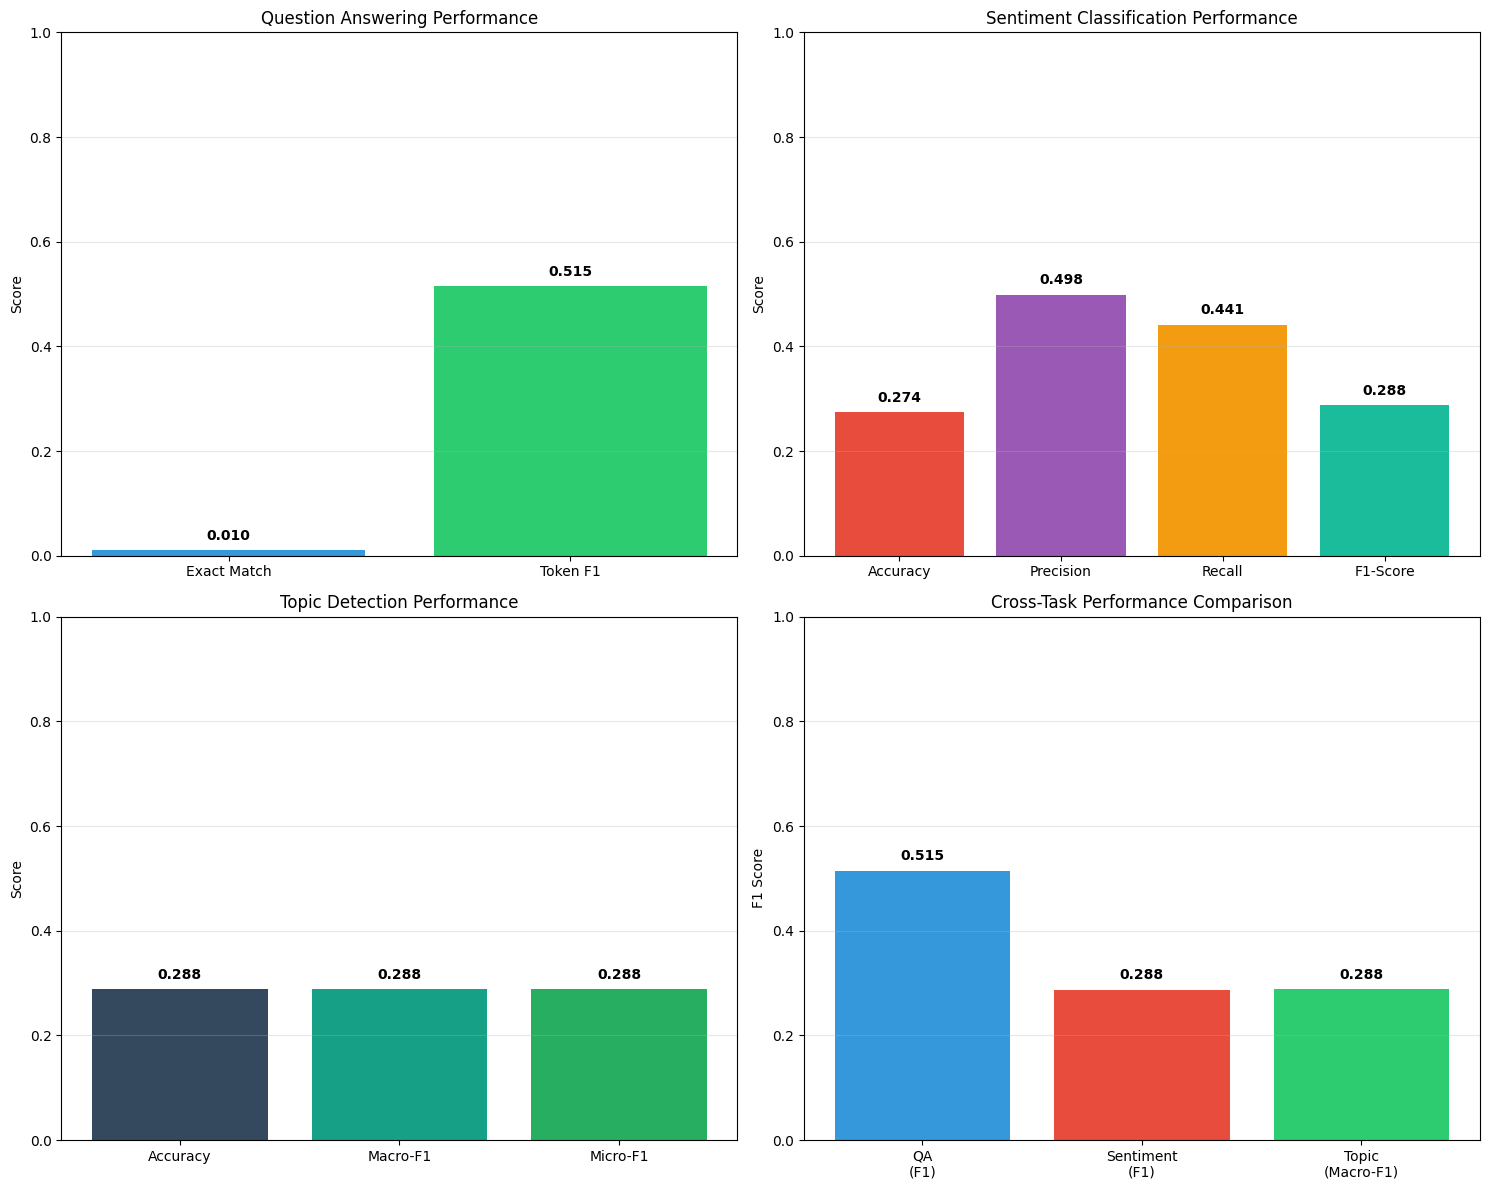

In [22]:
# ============================================================================
# 10. VISUALIZATION
# ============================================================================

print("\n" + "=" * 80)
print("GENERATING VISUALIZATIONS")
print("=" * 80)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: QA Performance
ax1 = axes[0, 0]
qa_metrics = ['Exact Match', 'Token F1']
qa_scores = [np.mean(qa_em_scores), np.mean(qa_f1_scores)]
ax1.bar(qa_metrics, qa_scores, color=['#3498db', '#2ecc71'])
ax1.set_ylim(0, 1)
ax1.set_ylabel('Score')
ax1.set_title('Question Answering Performance')
ax1.grid(axis='y', alpha=0.3)
for i, v in enumerate(qa_scores):
    ax1.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# Plot 2: Sentiment Classification
ax2 = axes[0, 1]
sent_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
sent_scores = [sent_accuracy, sent_precision, sent_recall, sent_f1]
ax2.bar(sent_metrics, sent_scores, color=['#e74c3c', '#9b59b6', '#f39c12', '#1abc9c'])
ax2.set_ylim(0, 1)
ax2.set_ylabel('Score')
ax2.set_title('Sentiment Classification Performance')
ax2.grid(axis='y', alpha=0.3)
for i, v in enumerate(sent_scores):
    ax2.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# Plot 3: Topic Detection
ax3 = axes[1, 0]
topic_metrics = ['Accuracy', 'Macro-F1', 'Micro-F1']
topic_scores = [topic_accuracy, topic_macro_f1, topic_micro_f1]
ax3.bar(topic_metrics, topic_scores, color=['#34495e', '#16a085', '#27ae60'])
ax3.set_ylim(0, 1)
ax3.set_ylabel('Score')
ax3.set_title('Topic Detection Performance')
ax3.grid(axis='y', alpha=0.3)
for i, v in enumerate(topic_scores):
    ax3.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# Plot 4: Task Comparison
ax4 = axes[1, 1]
tasks = ['QA\n(F1)', 'Sentiment\n(F1)', 'Topic\n(Macro-F1)']
comparison_scores = [np.mean(qa_f1_scores), sent_f1, topic_macro_f1]
colors = ['#3498db', '#e74c3c', '#2ecc71']
ax4.bar(tasks, comparison_scores, color=colors)
ax4.set_ylim(0, 1)
ax4.set_ylabel('F1 Score')
ax4.set_title('Cross-Task Performance Comparison')
ax4.grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_scores):
    ax4.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/financial_analysis_results.png', dpi=300, bbox_inches='tight')
print(" Visualizations saved as 'financial_analysis_results.png'")
plt.show()

In [23]:
# ============================================================================
# 11. SAVE RESULTS
# ============================================================================

print("\n" + "=" * 80)
print("SAVING RESULTS")
print("=" * 80)

# Save detailed predictions
output_df = df[['question', 'answer', 'context',
                'qa_pred', 'qa_em', 'qa_f1',
                'sentiment_true', 'sentiment_pred',
                'topic_true', 'topic_pred']]
output_df.to_csv(f'{OUTPUT_PATH}/financial_analysis_predictions.csv', index=False)
print(" Detailed predictions saved to 'financial_analysis_predictions.csv'")

# Save summary results
results_summary.to_csv(f'{OUTPUT_PATH}/financial_analysis_summary.csv', index=False)
print(" Summary results saved to 'financial_analysis_summary.csv'")

print("\n" + "=" * 80)
print("PIPELINE COMPLETED SUCCESSFULLY")
print("=" * 80)
print(f"\nModel: {MODEL_NAME}")
print(f"Prompting Strategy: Zero-Shot")
print(f"Total Records Processed: {len(df)}")
print(f"\nKey Findings:")
print(f"  - QA Token F1: {np.mean(qa_f1_scores):.3f}")
print(f"  - Sentiment F1: {sent_f1:.3f}")
print(f"  - Topic Macro-F1: {topic_macro_f1:.3f}")
print("=" * 80)


SAVING RESULTS
 Detailed predictions saved to 'financial_analysis_predictions.csv'
 Summary results saved to 'financial_analysis_summary.csv'

PIPELINE COMPLETED SUCCESSFULLY

Model: llama-3.1-8b-instant
Prompting Strategy: Zero-Shot
Total Records Processed: 1675

Key Findings:
  - QA Token F1: 0.515
  - Sentiment F1: 0.288
  - Topic Macro-F1: 0.288


In [36]:
import os
print("\n" + "=" * 80)
print("DATA LOADING AND PREPROCESSING")
print("=" * 80)

MODEL_NAME= 'llama-3.1-8b-instant'
DATAFILE_NAME= 'financial_analysis_predictions.csv'
DATA_PATH = f'../Outputs/Few-Shot/{MODEL_NAME}_1/{DATAFILE_NAME}'
if not os.path.exists(DATA_PATH):
    DATA_PATH = f'{DATAFILE_NAME}'  # Colab path
# Load dataset (replace with your actual path)
df = pd.read_csv(DATA_PATH)

OUTPUT_PATH = f'../Outputs/Few-Shot/{MODEL_NAME}_1/'

if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

print(f"\n Dataset loaded: {len(df)} records")
print(f" Columns: {list(df.columns)}")


DATA LOADING AND PREPROCESSING

 Dataset loaded: 1675 records
 Columns: ['question', 'answer', 'context', 'qa_pred', 'qa_em', 'qa_f1', 'sentiment_true', 'sentiment_pred', 'topic_true', 'topic_pred']


In [ ]:
# ============================================================================
# 12. EXPLAINABLE AI (XAI) - SENTIMENT CLASSIFICATION
# ============================================================================

print("\n" + "=" * 80)
print("EXPLAINABLE AI ANALYSIS")
print("=" * 80)

# ============================================================================
# 12.1 PREPARE SURROGATE MODEL FOR SENTIMENT
# ============================================================================

print("\n[1/4] Training surrogate model for Sentiment Classification...")

# Create TF-IDF features
tfidf_sent = TfidfVectorizer(max_features=100, lowercase=True, stop_words='english', ngram_range=(1, 2), dtype=float)
X_sent = tfidf_sent.fit_transform(df['context'])
# X_sent = tfidf_sent.fit_transform(df['combined_text'])

# Train a surrogate Random Forest model
rf_sent = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_sent.fit(X_sent, df['sentiment_true'])

print(f" Surrogate model trained (Accuracy: {rf_sent.score(X_sent, df['sentiment_true']):.3f})")


EXPLAINABLE AI ANALYSIS

[1/4] Training surrogate model for Sentiment Classification...
 Surrogate model trained (Accuracy: 0.760)



[2/4] Generating SHAP explanations for Sentiment...
 SHAP plots saved as 'xai_shap_sentiment.png'


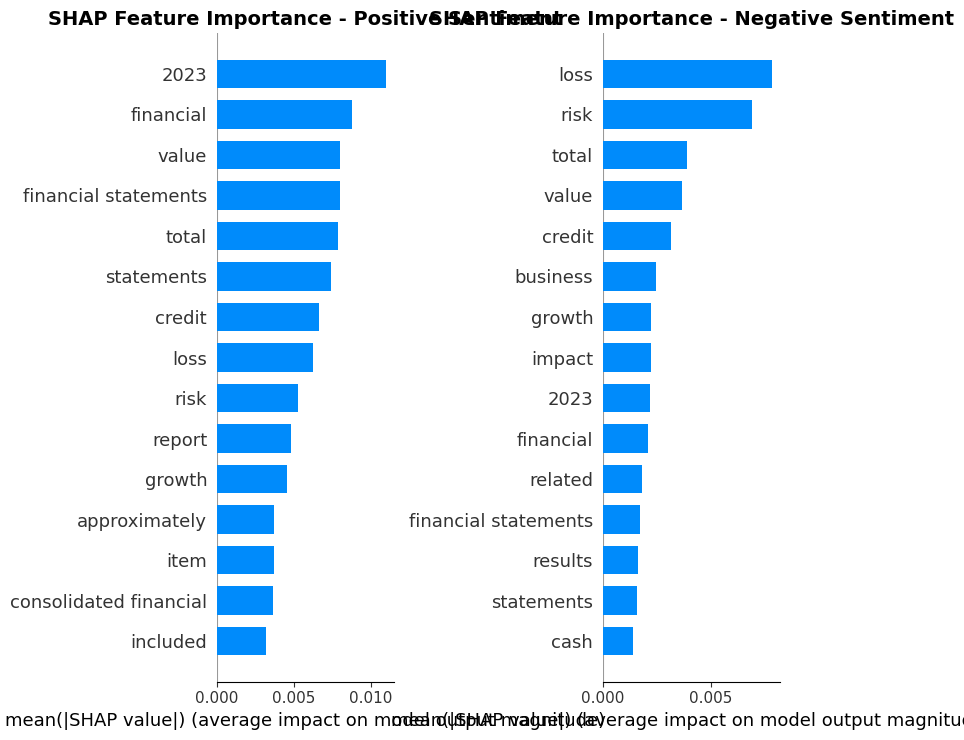


Generating SHAP force plot for sample prediction...


 SHAP waterfall plot saved as 'xai_shap_waterfall_sentiment.png'


<Figure size 1400x300 with 0 Axes>

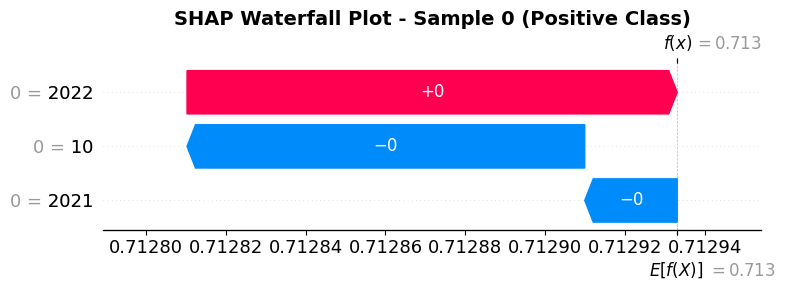

In [47]:
# ============================================================================
# 12.2 SHAP ANALYSIS FOR SENTIMENT
# ============================================================================

print("\n[2/4] Generating SHAP explanations for Sentiment...")

X_sent_dense = X_sent.toarray()

# Create SHAP explainer
explainer_sent = shap.TreeExplainer(rf_sent)
shap_values_sent = explainer_sent.shap_values(X_sent_dense)

# SHAP Summary Plot
fig_shap_sent, axes_shap = plt.subplots(1, 2, figsize=(18, 6))

# Plot for each sentiment class (assuming 3 classes: Negative=0, Neutral=1, Positive=2)
class_names_sent = ['Negative', 'Neutral', 'Positive']
feature_names_sent = tfidf_sent.get_feature_names_out()

shap_values_class_2 = shap_values_sent[:, :, 2]
# Summary plot for Positive class
if len(shap_values_sent) >= 3:
    plt.sca(axes_shap[0])
    shap_values_class_2 = shap_values_sent[:, :, 2]
    shap.summary_plot(shap_values_class_2, X_sent_dense,
                     feature_names=feature_names_sent,
                     plot_type="bar", show=False, max_display=15)
    axes_shap[0].set_title('SHAP Feature Importance - Positive Sentiment', fontsize=14, fontweight='bold')

    # Summary plot for Negative class
    plt.sca(axes_shap[1])
    shap_values_negative = shap_values_sent[:, :, 0]
    shap.summary_plot(shap_values_negative, X_sent,
                     feature_names=feature_names_sent,
                     plot_type="bar", show=False, max_display=15)
    axes_shap[1].set_title('SHAP Feature Importance - Negative Sentiment', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/xai_shap_sentiment.png', dpi=300, bbox_inches='tight')
print(" SHAP plots saved as 'xai_shap_sentiment.png'")
plt.show()

# SHAP Force Plot for a specific example
print("\nGenerating SHAP force plot for sample prediction...")
sample_idx = 0
shap.initjs()

# Individual SHAP explanation
if len(shap_values_sent) >= 3:
    fig_force = plt.figure(figsize=(14, 3))
    shap_explanation = shap.Explanation(
        values=shap_values_sent[2][sample_idx],
        base_values=explainer_sent.expected_value[2],
        data=X_sent[sample_idx].toarray()[0],
        feature_names=feature_names_sent
    )

    # Waterfall plot
    plt.figure(figsize=(12, 6))
    shap.plots.waterfall(shap_explanation, max_display=15, show=False)
    plt.title(f'SHAP Waterfall Plot - Sample {sample_idx} (Positive Class)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_PATH}/xai_shap_waterfall_sentiment.png', dpi=300, bbox_inches='tight')
    print(" SHAP waterfall plot saved as 'xai_shap_waterfall_sentiment.png'")
    plt.show()


[3/4] Generating LIME explanations for Sentiment...
 LIME plots saved as 'xai_lime_sentiment.png'


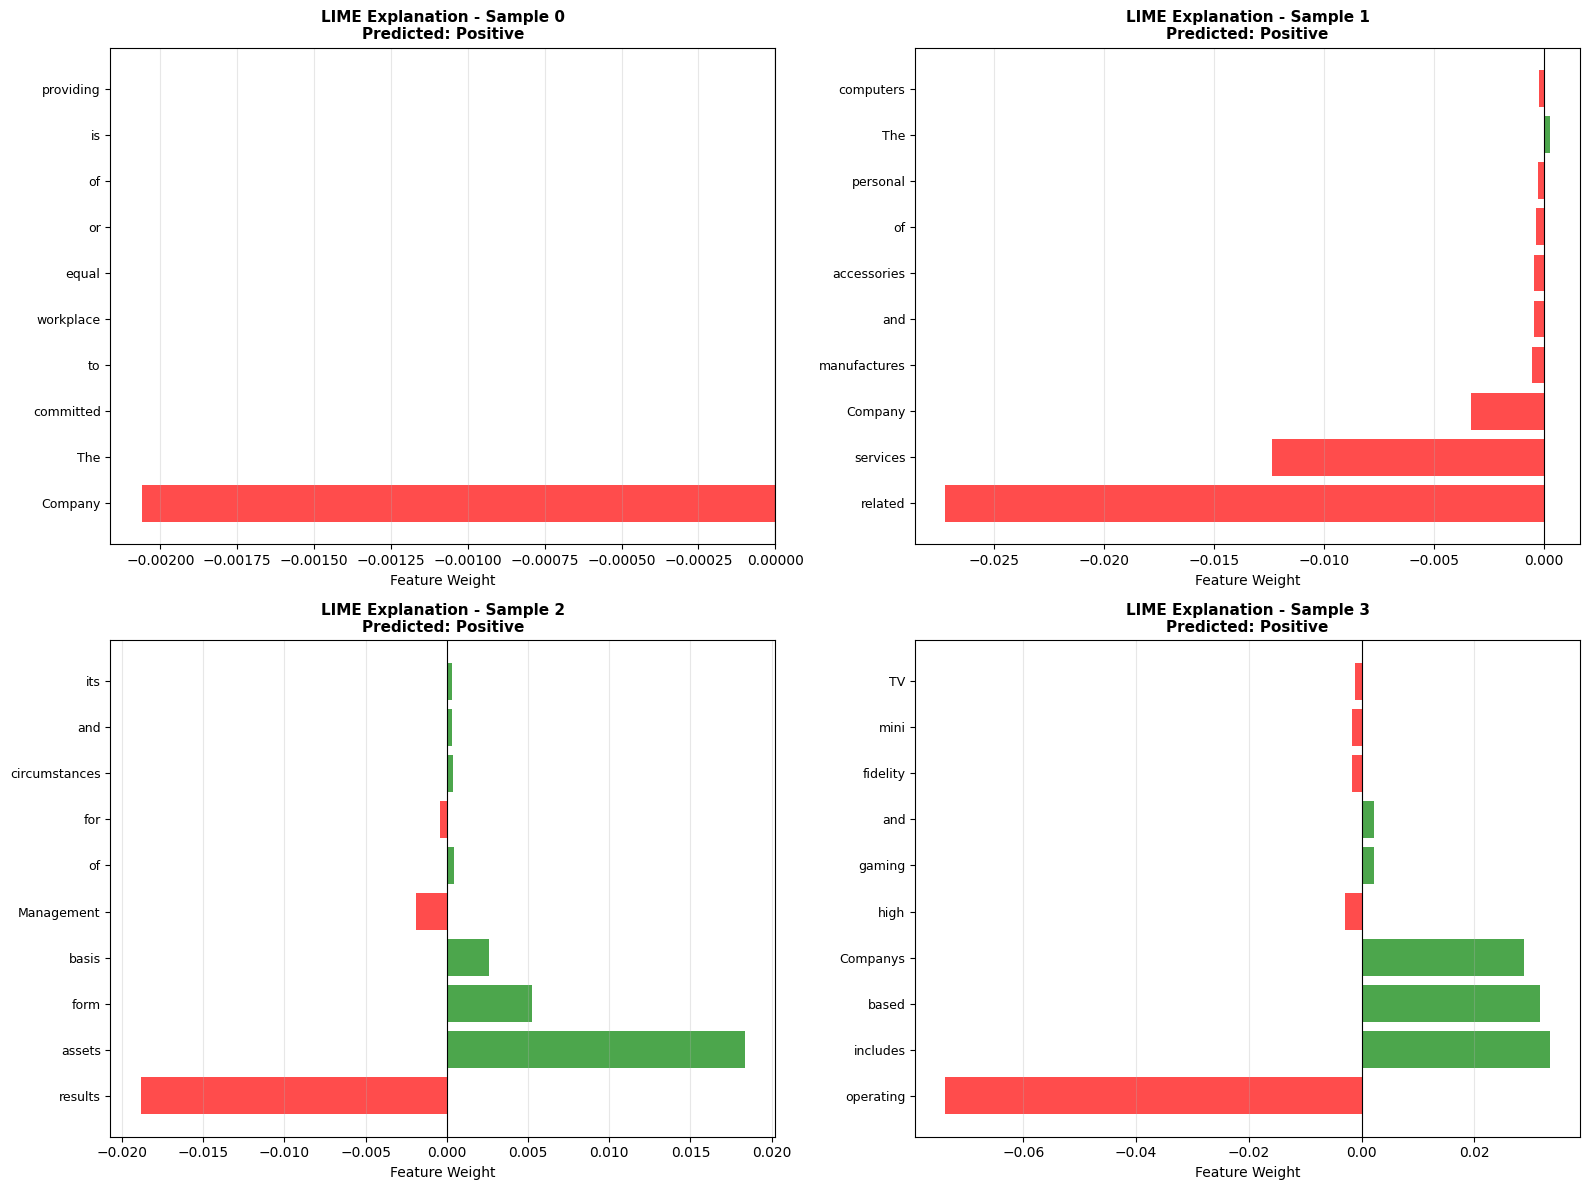

In [40]:
# ============================================================================
# 12.3 LIME ANALYSIS FOR SENTIMENT
# ============================================================================

print("\n[3/4] Generating LIME explanations for Sentiment...")

# Create LIME explainer
def sentiment_predictor(texts):
    """Prediction function for LIME"""
    X = tfidf_sent.transform(texts)
    return rf_sent.predict_proba(X)

lime_sent = LimeTextExplainer(class_names=class_names_sent)

# Generate LIME explanation for sample instances
lime_explanations_sent = []
fig_lime_sent, axes_lime = plt.subplots(2, 2, figsize=(16, 12))
axes_lime = axes_lime.flatten()

for idx in range(min(4, len(df))):
    exp = lime_sent.explain_instance(
        df.iloc[idx]['context'],
        sentiment_predictor,
        num_features=10,
        top_labels=1
    )
    lime_explanations_sent.append(exp)

    # Plot explanation
    fig_temp = exp.as_pyplot_figure(label=exp.top_labels[0])

    # Transfer to subplot
    ax = axes_lime[idx]
    ax.clear()

    # Get feature importance
    feat_imp = exp.as_list(label=exp.top_labels[0])
    features = [f[0] for f in feat_imp]
    weights = [f[1] for f in feat_imp]
    colors = ['green' if w > 0 else 'red' for w in weights]

    y_pos = np.arange(len(features))
    ax.barh(y_pos, weights, color=colors, alpha=0.7)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features, fontsize=9)
    ax.set_xlabel('Feature Weight', fontsize=10)
    ax.set_title(f'LIME Explanation - Sample {idx}\nPredicted: {class_names_sent[exp.top_labels[0]]}',
                 fontsize=11, fontweight='bold')
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    ax.grid(axis='x', alpha=0.3)

    plt.close(fig_temp)

plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/xai_lime_sentiment.png', dpi=300, bbox_inches='tight')
print(" LIME plots saved as 'xai_lime_sentiment.png'")
plt.show()

In [41]:
# ============================================================================
# 12.4 PREPARE SURROGATE MODEL FOR TOPIC DETECTION
# ============================================================================

print("\n[4/4] Training surrogate model for Topic Detection...")

# Create TF-IDF features for topics
tfidf_topic = TfidfVectorizer(max_features=100, lowercase=True, stop_words='english', ngram_range=(1, 2))
X_topic = tfidf_topic.fit_transform(df['question'])

# Train a surrogate Random Forest model
rf_topic = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_topic.fit(X_topic, df['topic_true'])

print(f" Surrogate model trained (Accuracy: {rf_topic.score(X_topic, df['topic_true']):.3f})")


[4/4] Training surrogate model for Topic Detection...
 Surrogate model trained (Accuracy: 0.922)



Generating SHAP explanations for Topic Detection...
 SHAP topic plots saved as 'xai_shap_topic.png'


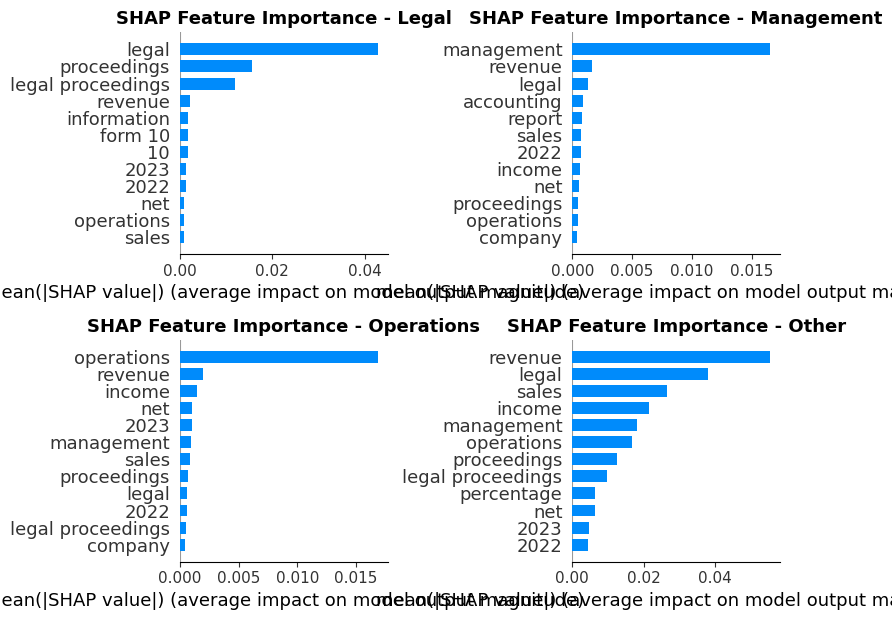

In [42]:
# ============================================================================
# 12.5 SHAP ANALYSIS FOR TOPIC DETECTION
# ============================================================================

print("\nGenerating SHAP explanations for Topic Detection...")

X_topic_dense = X_topic.toarray()

# Create SHAP explainer
explainer_topic = shap.TreeExplainer(rf_topic)
shap_values_topic = explainer_topic.shap_values(X_topic_dense)

# SHAP Summary Plot for Topics
fig_shap_topic, axes_shap_topic = plt.subplots(2, 2, figsize=(18, 12))
axes_shap_topic = axes_shap_topic.flatten()

# Get unique topics and their indices
unique_topics = rf_topic.classes_
feature_names_topic = tfidf_topic.get_feature_names_out()

for i, topic in enumerate(unique_topics[:4]):  # Show first 4 topics
    if i < len(shap_values_topic):
        plt.sca(axes_shap_topic[i])
        shap_values_class_i = shap_values_topic[:, :, i]
        shap.summary_plot(shap_values_class_i, X_topic,
                         feature_names=feature_names_topic,
                         plot_type="bar", show=False, max_display=12)
        axes_shap_topic[i].set_title(f'SHAP Feature Importance - {topic}',
                                     fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/xai_shap_topic.png', dpi=300, bbox_inches='tight')
print(" SHAP topic plots saved as 'xai_shap_topic.png'")
plt.show()


Generating LIME explanations for Topic Detection...
 LIME topic plots saved as 'xai_lime_topic.png'


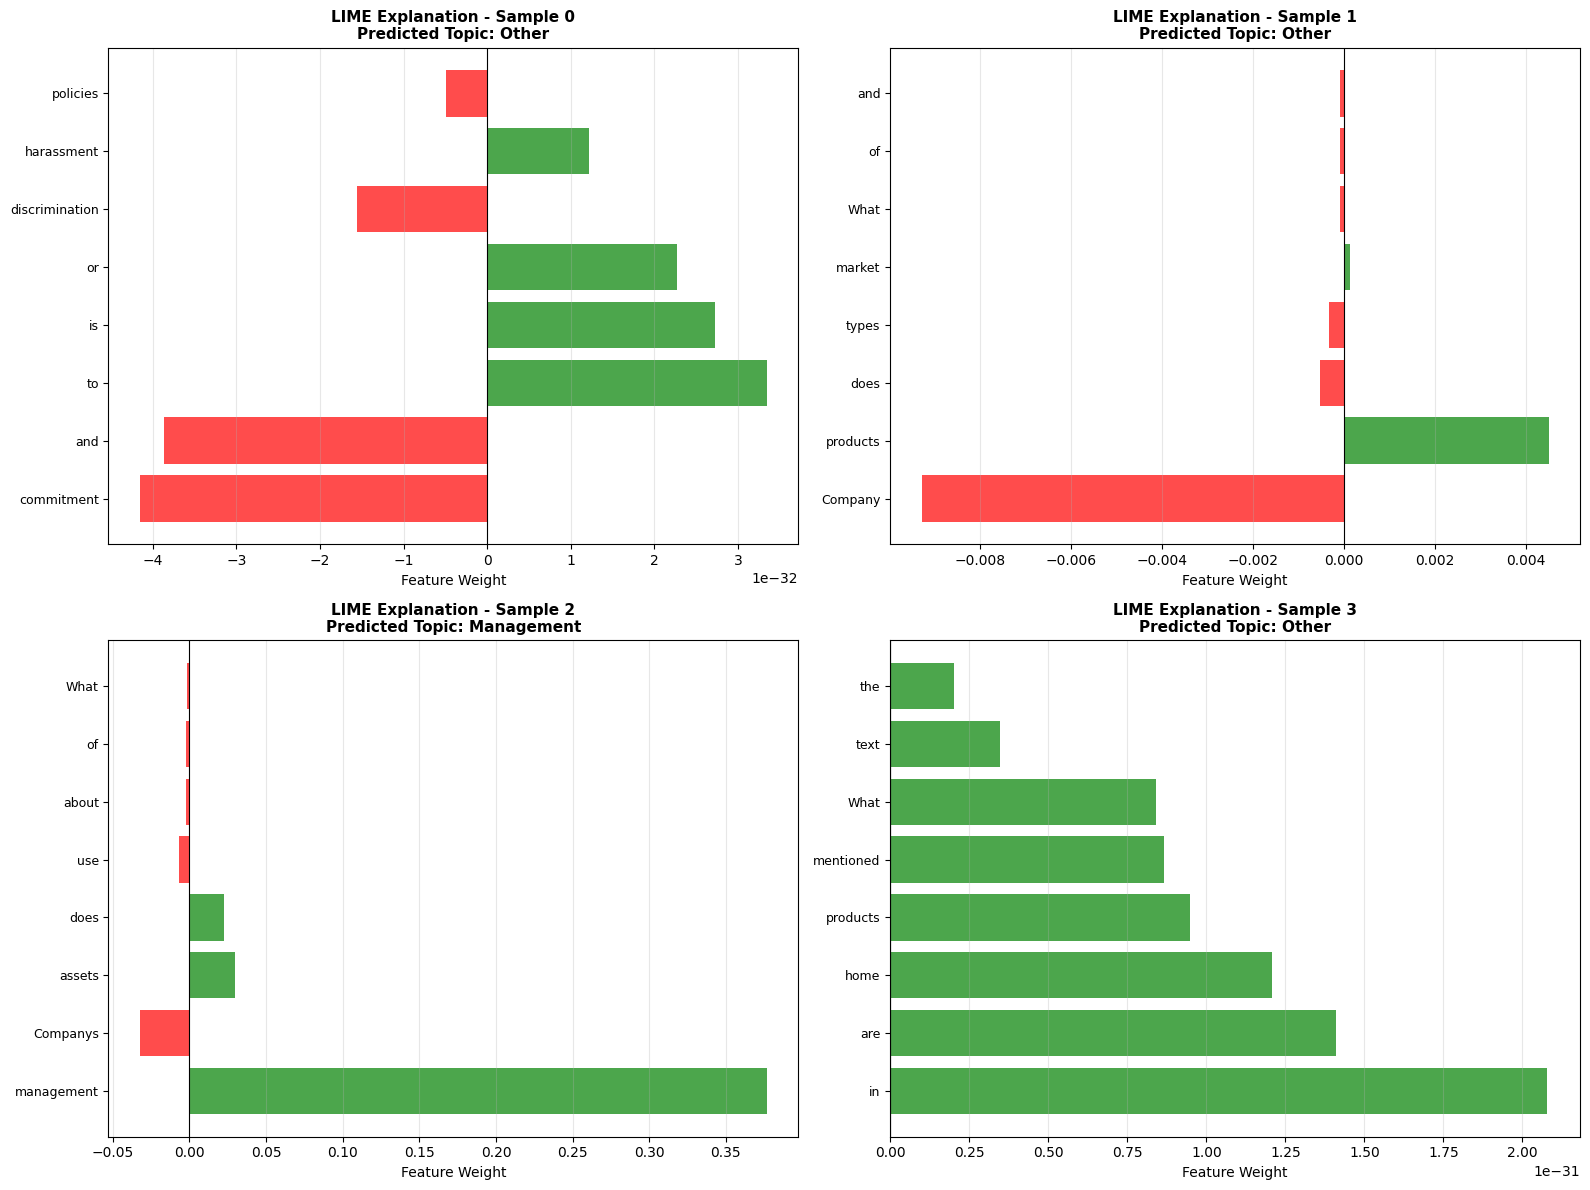

In [43]:
# ============================================================================
# 12.6 LIME ANALYSIS FOR TOPIC DETECTION
# ============================================================================

print("\nGenerating LIME explanations for Topic Detection...")

# Create LIME explainer for topics
def topic_predictor(texts):
    """Prediction function for LIME"""
    X = tfidf_topic.transform(texts)
    return rf_topic.predict_proba(X)

lime_topic = LimeTextExplainer(class_names=unique_topics.tolist())

# Generate LIME explanation for sample instances
fig_lime_topic, axes_lime_topic = plt.subplots(2, 2, figsize=(16, 12))
axes_lime_topic = axes_lime_topic.flatten()

for idx in range(min(4, len(df))):
    exp = lime_topic.explain_instance(
        df.iloc[idx]['question'],
        topic_predictor,
        num_features=8,
        top_labels=1
    )

    # Plot explanation
    ax = axes_lime_topic[idx]
    ax.clear()

    # Get feature importance
    feat_imp = exp.as_list(label=exp.top_labels[0])
    features = [f[0] for f in feat_imp]
    weights = [f[1] for f in feat_imp]
    colors = ['green' if w > 0 else 'red' for w in weights]

    y_pos = np.arange(len(features))
    ax.barh(y_pos, weights, color=colors, alpha=0.7)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features, fontsize=9)
    ax.set_xlabel('Feature Weight', fontsize=10)
    pred_topic = unique_topics[exp.top_labels[0]]
    ax.set_title(f'LIME Explanation - Sample {idx}\nPredicted Topic: {pred_topic}',
                 fontsize=11, fontweight='bold')
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/xai_lime_topic.png', dpi=300, bbox_inches='tight')
print(" LIME topic plots saved as 'xai_lime_topic.png'")
plt.show()


Generating Feature Importance Comparison...
 Feature importance plots saved as 'xai_feature_importance.png'


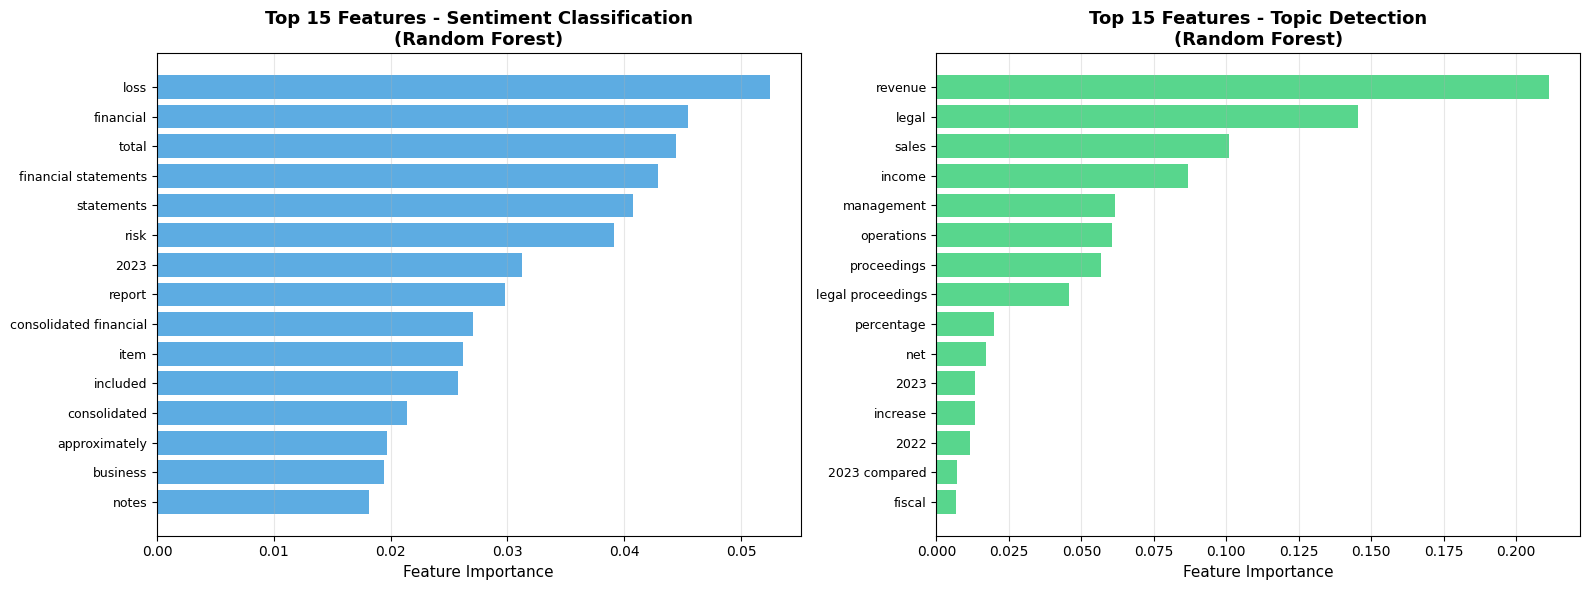

In [44]:
# ============================================================================
# 12.7 FEATURE IMPORTANCE COMPARISON
# ============================================================================

print("\nGenerating Feature Importance Comparison...")

fig_importance, axes_imp = plt.subplots(1, 2, figsize=(16, 6))

# Sentiment Feature Importance
feature_importance_sent = rf_sent.feature_importances_
top_n = 15
indices_sent = np.argsort(feature_importance_sent)[-top_n:]
top_features_sent = [feature_names_sent[i] for i in indices_sent]
top_importance_sent = feature_importance_sent[indices_sent]

axes_imp[0].barh(range(top_n), top_importance_sent, color='#3498db', alpha=0.8)
axes_imp[0].set_yticks(range(top_n))
axes_imp[0].set_yticklabels(top_features_sent, fontsize=9)
axes_imp[0].set_xlabel('Feature Importance', fontsize=11)
axes_imp[0].set_title('Top 15 Features - Sentiment Classification\n(Random Forest)',
                      fontsize=13, fontweight='bold')
axes_imp[0].grid(axis='x', alpha=0.3)

# Topic Feature Importance
feature_importance_topic = rf_topic.feature_importances_
indices_topic = np.argsort(feature_importance_topic)[-top_n:]
top_features_topic = [feature_names_topic[i] for i in indices_topic]
top_importance_topic = feature_importance_topic[indices_topic]

axes_imp[1].barh(range(top_n), top_importance_topic, color='#2ecc71', alpha=0.8)
axes_imp[1].set_yticks(range(top_n))
axes_imp[1].set_yticklabels(top_features_topic, fontsize=9)
axes_imp[1].set_xlabel('Feature Importance', fontsize=11)
axes_imp[1].set_title('Top 15 Features - Topic Detection\n(Random Forest)',
                      fontsize=13, fontweight='bold')
axes_imp[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/xai_feature_importance.png', dpi=300, bbox_inches='tight')
print(" Feature importance plots saved as 'xai_feature_importance.png'")
plt.show()

In [45]:
# ============================================================================
# 12.8 XAI METRICS AND SUMMARY
# ============================================================================

print("\n" + "=" * 80)
print("XAI ANALYSIS SUMMARY")
print("=" * 80)

# Calculate explainability metrics
xai_metrics = {
    'Task': [],
    'Surrogate Model Accuracy': [],
    'Top Feature': [],
    'Feature Importance': []
}

# Sentiment XAI metrics
xai_metrics['Task'].append('Sentiment Classification')
xai_metrics['Surrogate Model Accuracy'].append(f"{rf_sent.score(X_sent, df['sentiment_true']):.4f}")
top_sent_idx = np.argmax(feature_importance_sent)
xai_metrics['Top Feature'].append(feature_names_sent[top_sent_idx])
xai_metrics['Feature Importance'].append(f"{feature_importance_sent[top_sent_idx]:.4f}")

# Topic XAI metrics
xai_metrics['Task'].append('Topic Detection')
xai_metrics['Surrogate Model Accuracy'].append(f"{rf_topic.score(X_topic, df['topic_true']):.4f}")
top_topic_idx = np.argmax(feature_importance_topic)
xai_metrics['Top Feature'].append(feature_names_topic[top_topic_idx])
xai_metrics['Feature Importance'].append(f"{feature_importance_topic[top_topic_idx]:.4f}")

xai_summary_df = pd.DataFrame(xai_metrics)
print("\n", xai_summary_df.to_string(index=False))

# Save XAI summary
xai_summary_df.to_csv(f'{OUTPUT_PATH}/xai_analysis_summary.csv', index=False)
print("\n XAI summary saved to 'xai_analysis_summary.csv'")


XAI ANALYSIS SUMMARY

                     Task Surrogate Model Accuracy Top Feature Feature Importance
Sentiment Classification                   0.7599        loss             0.0525
         Topic Detection                   0.9217     revenue             0.2115

 XAI summary saved to 'xai_analysis_summary.csv'


In [46]:
# ============================================================================
# 12.9 DETAILED XAI EXPLANATIONS FOR KEY INSTANCES
# ============================================================================

print("\n" + "-" * 80)
print("DETAILED XAI EXPLANATIONS FOR KEY INSTANCES")
print("-" * 80)

# Select one instance from each task for detailed explanation
sample_idx_detailed = 0

print(f"\n Sample {sample_idx_detailed} - Detailed Analysis")
print("-" * 80)

# Original data
print(f"\nOriginal Context: {df.iloc[sample_idx_detailed]['context'][:200]}...")
print(f"True Sentiment: {df.iloc[sample_idx_detailed]['sentiment_true']}")
print(f"Predicted Sentiment: {df.iloc[sample_idx_detailed]['sentiment_pred']}")

# SHAP values for this instance
if len(shap_values_sent) >= 3:
    print(f"\nTop 5 SHAP Features (Sentiment):")
    shap_instance = shap_values_sent[2][sample_idx_detailed]  # Positive class
    top_shap_indices = np.argsort(np.abs(shap_instance))[-5:][::-1]
    for i, idx in enumerate(top_shap_indices, 1):
        print(f"  {i}. {feature_names_sent[idx]}: {shap_instance[idx]:.4f}")

# LIME explanation
print(f"\nLIME Explanation (Sentiment):")
lime_exp_detailed = lime_explanations_sent[sample_idx_detailed]
for feat, weight in lime_exp_detailed.as_list(label=lime_exp_detailed.top_labels[0])[:5]:
    print(f"  '{feat}': {weight:.4f}")

print("\n" + "=" * 80)
print("XAI ANALYSIS COMPLETED")
print("=" * 80)
print("\n Generated Visualizations:")
print("  1. xai_shap_sentiment.png - SHAP feature importance for sentiment")
print("  2. xai_shap_waterfall_sentiment.png - SHAP waterfall plot")
print("  3. xai_lime_sentiment.png - LIME explanations for sentiment")
print("  4. xai_shap_topic.png - SHAP feature importance for topics")
print("  5. xai_lime_topic.png - LIME explanations for topics")
print("  6. xai_feature_importance.png - Feature importance comparison")
print("\n Saved Reports:")
print("  1. xai_analysis_summary.csv - XAI metrics summary")

print("\n" + "=" * 80)
print("COMPLETE PIPELINE FINISHED")
print("=" * 80)


--------------------------------------------------------------------------------
DETAILED XAI EXPLANATIONS FOR KEY INSTANCES
--------------------------------------------------------------------------------

 Sample 0 - Detailed Analysis
--------------------------------------------------------------------------------

Original Context: The Company is an equal opportunity employer committed to inclusion and diversity and to providing a workplace free of harassment or discrimination....
True Sentiment: Positive
Predicted Sentiment: Neutral

Top 5 SHAP Features (Sentiment):
  1. 2022: 0.0001
  2. 10: -0.0001
  3. 2021: -0.0000

LIME Explanation (Sentiment):
  'Company': -0.0021
  'The': -0.0000
  'committed': -0.0000
  'to': -0.0000
  'workplace': -0.0000

XAI ANALYSIS COMPLETED

 Generated Visualizations:
  1. xai_shap_sentiment.png - SHAP feature importance for sentiment
  2. xai_shap_waterfall_sentiment.png - SHAP waterfall plot
  3. xai_lime_sentiment.png - LIME explanations for senti